# Milestone 2: baseline models
___

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

import import_preprocess, baseline_models, evaluate
from importlib import reload
reload(import_preprocess)
reload(baseline_models)
reload(evaluate)

from import_preprocess import ImportPreprocess
from evaluate import Evaluation
from baseline_models import XGBoostClassifier, MajorityClassClassifier, NaiveBayesClassifier

In [2]:
import_preprocess = ImportPreprocess()
import_preprocess.import_train_val_test()

X_train, y_train = import_preprocess.X_train, import_preprocess.y_train
X_val, y_val = import_preprocess.X_val, import_preprocess.y_val
X_test, y_test = import_preprocess.X_test, import_preprocess.y_test

print("Number of training samples:", len(X_train)) 
print("Number of validation samples:", len(X_val))
print("Number of test samples:", len(X_test)) 

Number of training samples: 14000
Number of validation samples: 2000
Number of test samples: 4000


In [3]:
# import_preprocess.convert_class_labels()
# y_train, y_dev, y_test = import_preprocess.y_train, import_preprocess.y_dev, import_preprocess.y_test

In [4]:
X_train_dev, y_train_val = import_preprocess.concatenate_train_val()
len(X_train_dev)

16000

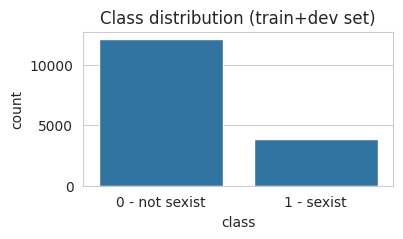

In [5]:
plt.figure(figsize=(4, 2))
sns.countplot(x=y_train_val)
plt.xticks(ticks=[0, 1], labels=['0 - not sexist', '1 - sexist'])
plt.title('Class distribution (train+dev set)')
plt.xlabel('class')
plt.ylabel('count')

plt.show()

#### a) Traditional (non-DL) baseline models

1. majority class classifier

Majority class: not sexist

########################################

Metrics for train_val
accuracy: 0.7572
balanced accuracy: 0.5000
precision: 0.0000
recall: 0.0000

########################################

Metrics for test
accuracy: 0.7575
balanced accuracy: 0.5000
precision: 0.0000
recall: 0.0000

########################################



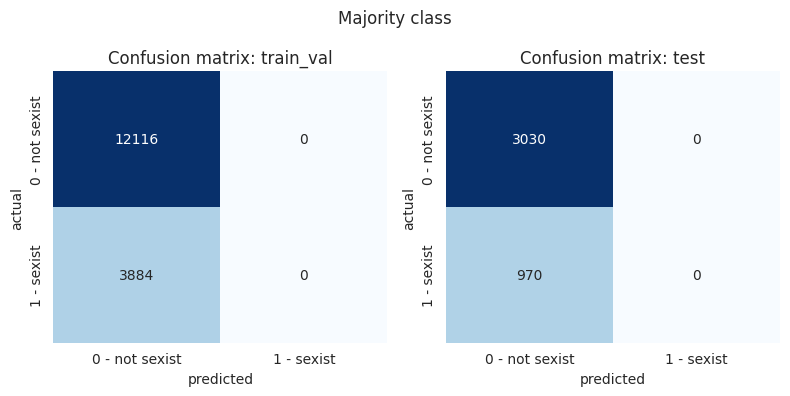

In [6]:
majority_class_classifier = MajorityClassClassifier()
majority_class_classifier.train(None, y_train_val, None, None)
print(f"Majority class: {majority_class_classifier.majority_class}\n")

majority_class_classifier.evaluate({"train_val": X_train_dev, "test": X_test}, [y_train_val, y_test], model_name="Majority class")

In [ ]:
evaluation = Evaluation()

2. regex classifier

3. Naive Bayes (NB)

########################################

Metrics for train_val
accuracy: 0.8167
balanced accuracy: 0.6664
precision: 0.7430
recall: 0.3743

########################################

Metrics for test
accuracy: 0.7975
balanced accuracy: 0.6301
precision: 0.6884
recall: 0.3045

########################################



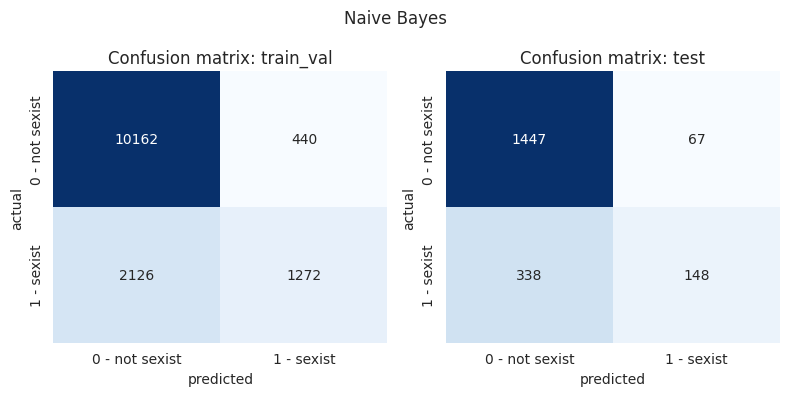

In [8]:
X_train_bow, X_val_bow, X_test_bow, X_train_val_bow, feature_names = import_preprocess.create_bow_representation()

naive_base_classifier = NaiveBayesClassifier()
naive_base_classifier.train(X_train_bow, y_train, None, None)

naive_base_classifier.evaluate({"train_val": X_train_bow, "test": X_val_bow}, [y_train, y_val], model_name="Naive Bayes")

4. XGBoost (using BoW representation)

[0]	train-logloss:0.53193	eval-logloss:0.53723
[1]	train-logloss:0.51431	eval-logloss:0.52352
[2]	train-logloss:0.50007	eval-logloss:0.51216
[3]	train-logloss:0.48820	eval-logloss:0.50334
[4]	train-logloss:0.47855	eval-logloss:0.49671
[5]	train-logloss:0.47021	eval-logloss:0.49069
[6]	train-logloss:0.46321	eval-logloss:0.48565
[7]	train-logloss:0.45708	eval-logloss:0.48162
[8]	train-logloss:0.45157	eval-logloss:0.47800
[9]	train-logloss:0.44715	eval-logloss:0.47518
[10]	train-logloss:0.44303	eval-logloss:0.47317
[11]	train-logloss:0.43920	eval-logloss:0.47105
[12]	train-logloss:0.43602	eval-logloss:0.46948
[13]	train-logloss:0.43282	eval-logloss:0.46714
[14]	train-logloss:0.43031	eval-logloss:0.46602
[15]	train-logloss:0.42782	eval-logloss:0.46496
[16]	train-logloss:0.42549	eval-logloss:0.46407
[17]	train-logloss:0.42322	eval-logloss:0.46317
[18]	train-logloss:0.42098	eval-logloss:0.46199


/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [11:59:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[19]	train-logloss:0.41915	eval-logloss:0.46103
[20]	train-logloss:0.41745	eval-logloss:0.46053
[21]	train-logloss:0.41599	eval-logloss:0.45983
[22]	train-logloss:0.41407	eval-logloss:0.45950
[23]	train-logloss:0.41194	eval-logloss:0.45936
[24]	train-logloss:0.41034	eval-logloss:0.45900
[25]	train-logloss:0.40895	eval-logloss:0.45835
[26]	train-logloss:0.40769	eval-logloss:0.45837
[27]	train-logloss:0.40617	eval-logloss:0.45822
[28]	train-logloss:0.40462	eval-logloss:0.45830
[29]	train-logloss:0.40329	eval-logloss:0.45766
[30]	train-logloss:0.40199	eval-logloss:0.45758
[31]	train-logloss:0.40081	eval-logloss:0.45708
[32]	train-logloss:0.39970	eval-logloss:0.45705
[33]	train-logloss:0.39871	eval-logloss:0.45696
[34]	train-logloss:0.39756	eval-logloss:0.45708
[35]	train-logloss:0.39661	eval-logloss:0.45697
[36]	train-logloss:0.39575	eval-logloss:0.45689
[37]	train-logloss:0.39457	eval-logloss:0.45659
[38]	train-logloss:0.39364	eval-logloss:0.45668
[39]	train-logloss:0.39237	eval-logloss:

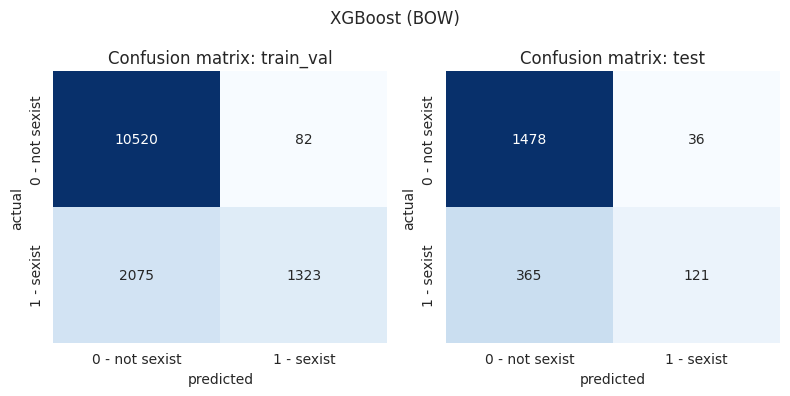

In [11]:
xg_boost_bow = XGBoostClassifier()
xg_boost_bow.train(X_train_bow, y_train, X_val_bow, y_val)

xg_boost_bow.evaluate({"train_val": X_train_bow, "test": X_val_bow}, [y_train, y_val], model_name="XGBoost (BOW)")

5. XGBoost (word embeddings representation)

#### b) DL baseline models

1. RNN

...